In [59]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Local modules
sys.path.append('../src')
from train import train_model
from visualize import imshow, visualize_model
from utils import unpickle, save_pickle

In [60]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms


In [7]:
# Script runtime options
root_dir = '..' # '/home/jupyter/caltech_birds'
model = 'vgg16'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [8]:
# Get data transforms
data_transforms = makeTransforms()

In [9]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [10]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cpu


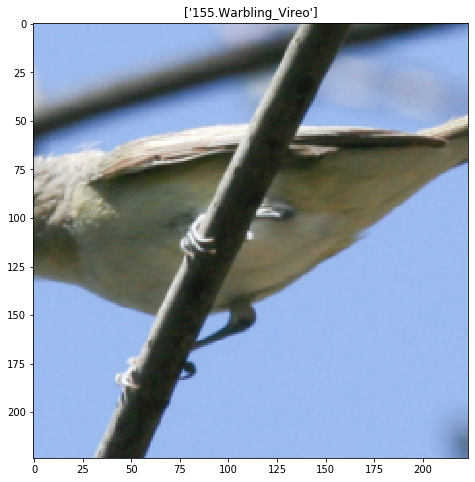

In [11]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
# Load the extracted feature maps
feature_maps_dict = unpickle(os.path.join(output_dir,'vgg_feature_extractions.pkl'))
features = np.array(feature_maps_dict['feature extractions (Final FC Layer)']).squeeze()

In [28]:
features.shape

(5794, 4096)

# Domain Reduction - Principal Components Analysis

## Assess all components

Compute all components to assess the number of components required to reconstruct 95% of the feature map information.

In [27]:
# Domain reduction
from sklearn.decomposition import PCA

In [30]:
pca = PCA()
pca.fit(features)

In [36]:
cum_explained_variance_ratio= []
cumsum=0.
for comp in pca.explained_variance_ratio_:
    cumsum += comp
    cum_explained_variance_ratio.append( cumsum )

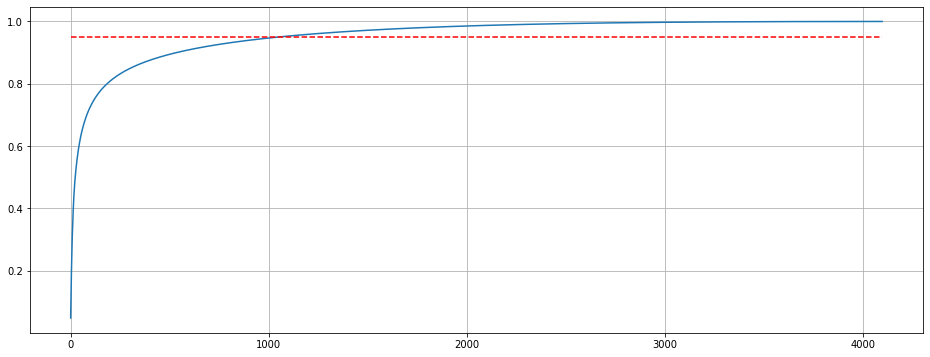

In [61]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.show()

## Compute the PCA transform and apply to the feature maps

1000 components was found to recover ~95% of the variance in the data.
This is domain reduction from 4096 to 1000 dimensions.

In [43]:
pca = PCA(n_components=1000)
pca.fit(features)

PCA(n_components=1000)

In [44]:
pca_features = pca.transform(features)

In [45]:
pca_features.shape

(5794, 1000)

In [46]:
pca_features_dict = {'pca_features' : pca_features,
                     'pca_model' : pca,
                     'n_components' : 1000,
                     'cumulative explained variance ratio (all components)' : cum_explained_variance_ratio}

In [47]:
save_pickle(pca_features_dict, os.path.join(output_dir,'vgg_pca_feature_extractions.pkl'))

# Manifold Learning Representations
## t-SNE of image feature maps

In [48]:
from sklearn.manifold import TSNE

In [66]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=50, angle=0.2, verbose=2).fit_transform(pca_features)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5794 samples in 0.399s...
[t-SNE] Computed neighbors for 5794 samples in 60.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5794
[t-SNE] Computed conditional probabilities for sample 2000 / 5794
[t-SNE] Computed conditional probabilities for sample 3000 / 5794
[t-SNE] Computed conditional probabilities for sample 4000 / 5794
[t-SNE] Computed conditional probabilities for sample 5000 / 5794
[t-SNE] Computed conditional probabilities for sample 5794 / 5794
[t-SNE] Mean sigma: 16.863172
[t-SNE] Computed conditional probabilities in 0.473s
[t-SNE] Iteration 50: error = 84.0280914, gradient norm = 0.0000883 (50 iterations in 5.753s)
[t-SNE] Iteration 100: error = 81.7311630, gradient norm = 0.0011526 (50 iterations in 3.810s)
[t-SNE] Iteration 150: error = 81.5870209, gradient norm = 0.0014129 (50 iterations in 3.291s)
[t-SNE] Iteration 200: error = 81.1803436, gradient norm = 0.0001915 (50 iterations in 6.311s)

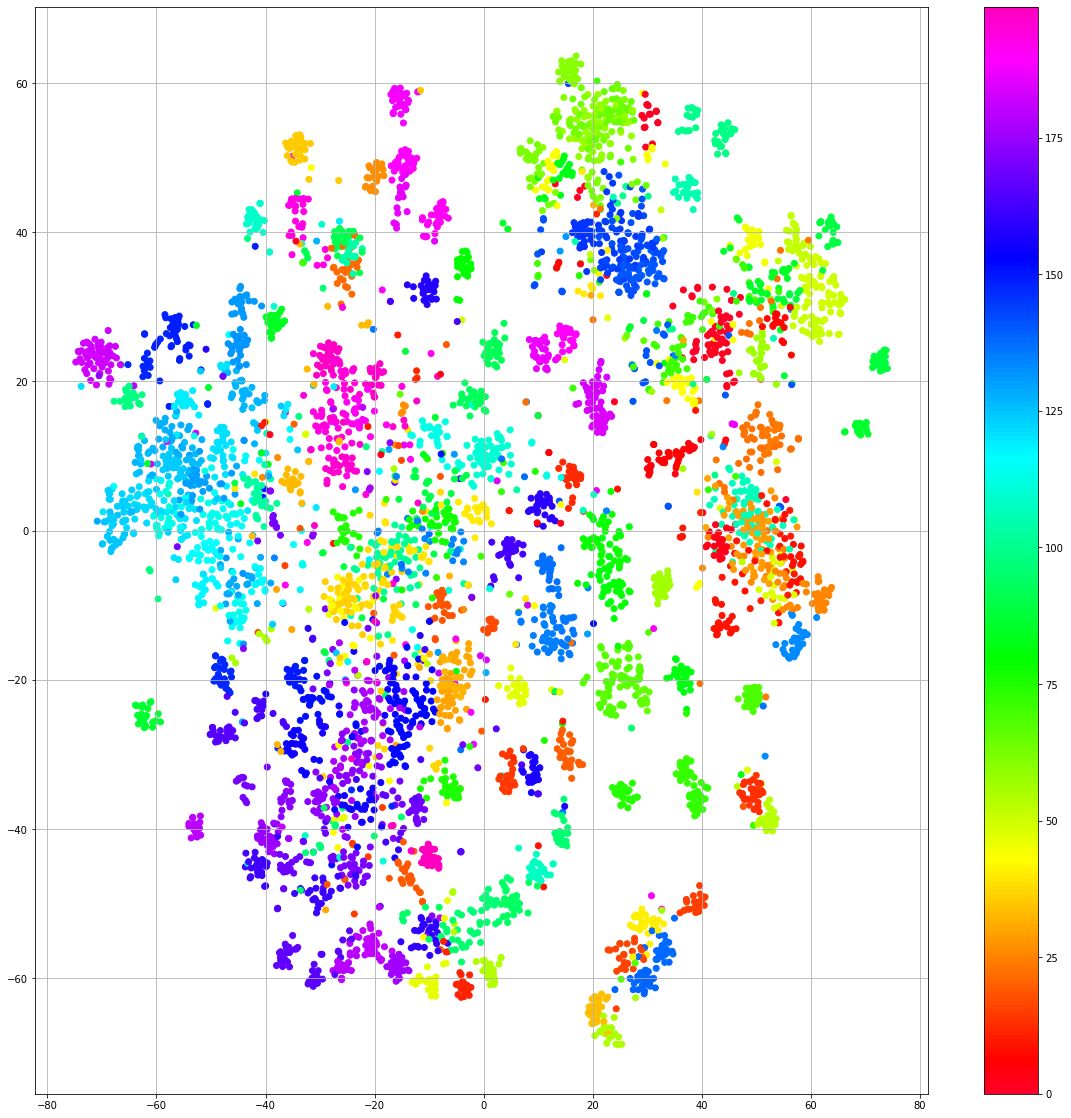

In [67]:
plt.figure(figsize=(20,20))
plt.scatter(tsne[:,0], tsne[:,1], c=feature_maps_dict['labels truth'], cmap='gist_rainbow')
plt.colorbar()
plt.grid(True)
plt.show()

## UMAP of image feature maps

In [68]:
from umap import UMAP

In [91]:
umap = UMAP(n_neighbors=30,
            min_dist=0.05,
            n_components=2,
            metric='euclidean')

In [92]:
umap_features = umap.fit_transform(pca_features)

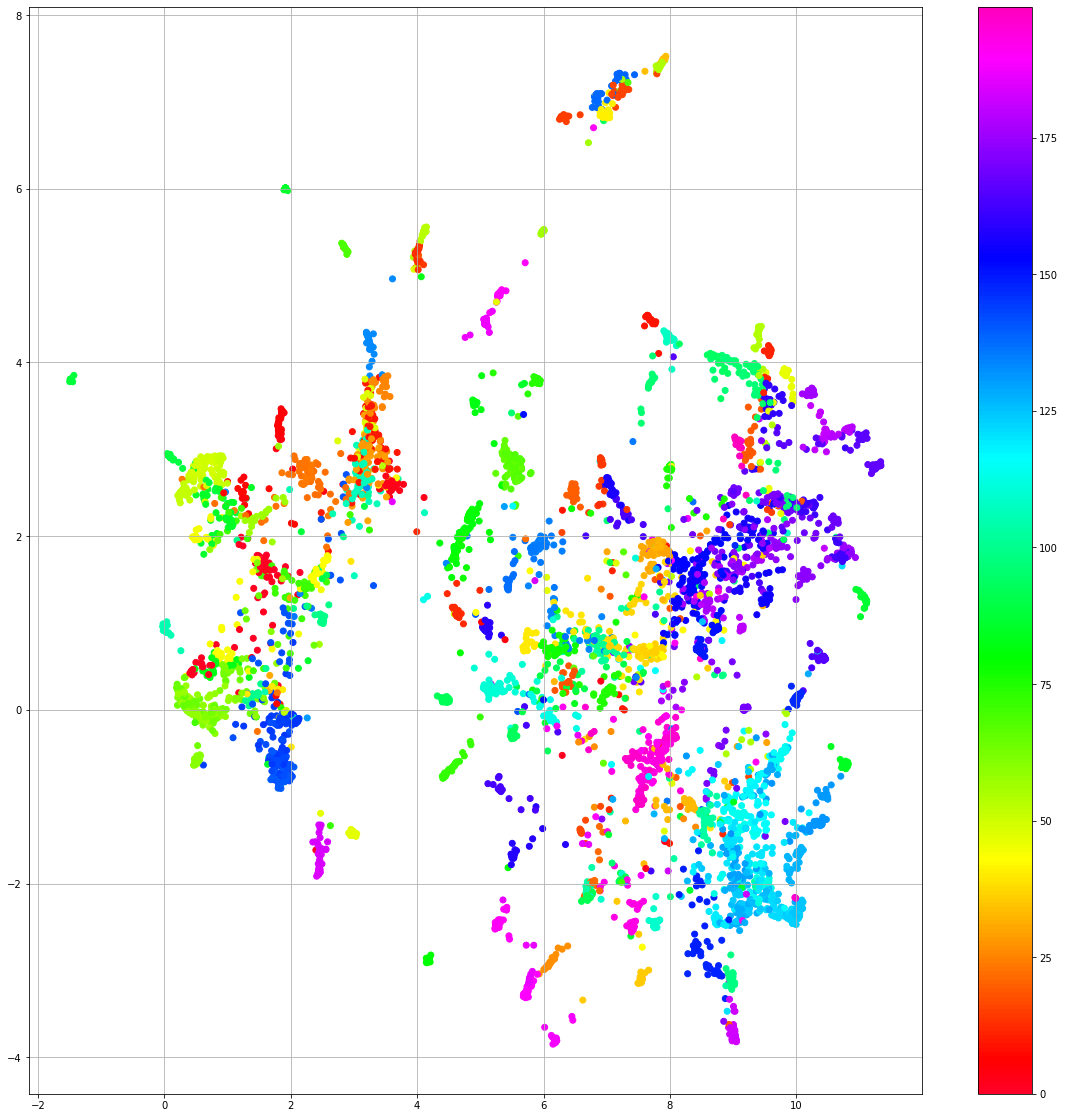

In [93]:
plt.figure(figsize=(20,20))
plt.scatter(umap_features[:,0], umap_features[:,1], c=feature_maps_dict['labels truth'], cmap='gist_rainbow')
plt.colorbar()
plt.grid(True)
plt.show()